# The purpose of this notebook is to give an example of the usage of the factorization method used in some of my works.

### After factorization, a simple total moment sum rule analysis along with a first moment sum rule analysis is performed. Some of the fitting utilities, in particular the unceratinty determination, are also shown.

Steps like absorption corrections, normalization, and others are skipped as they are shown in other notebooks. The definition of the factorization itself may be found in my disseration.



/home/tom/anaconda3/envs/mantid/lib/python3.6/site-packages/h5py/__init__.py:40: UserWarning: h5py is running against HDF5 1.10.0 when it was built against 1.10.6, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


 Material.formula_weight=(val)

######################

a = 5.3489 Ang
b = 9.2431 Ang
c = 4.8734 Ang
alpha = 90.0 Ang
beta = 111.44 Ang
gamma = 90.0 Ang
C 1 2/m 1
Space group: C 1 2/m 1
Unit Cell Volume =224.27
Formula weight = 100.0
Formula units per unit cell = 2
h3liir2o6.cif imported successfully.

###################### 



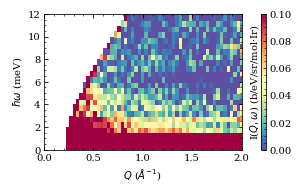

In [1]:
# First, import a dataset.
import thpyutils.material as material
import thpyutils.neutron.mdwrapper as mdwrapper
import matplotlib.pyplot as plt
from mantid.simpleapi import  *
import matplotlib
%matplotlib inline

# Specification of the necessary files.
ciffile = 'h3liir2o6.cif'
filename = '30_4K_SEQ_mag.nxs'

hlio = material.Material(cif_file = ciffile)
hlio_seq = mdwrapper.MDwrapper(name='HLIO_testing',filename=filename)

#Specify various measurement properties
hlio_seq.instrument='SEQ'
hlio_seq.temperature = 200.0 #in K
hlio_seq.Ei=30.0
hlio_seq.field = 0.0 # in T
#Import the nxspe file by spcifying binning params
Qslice = [0,4.0,0.05]
Eslice = [-20,25,0.5]
#Note in this case this is not an NXSPE file but instead a pre-binned nxs file containing an MDHistoworkspace.
hlioMagMD = LoadMD(filename)
hlio_seq.mdhisto = hlioMagMD
fig,ax = plt.subplots(1,1,figsize=(3.54,2.5),subplot_kw={'projection':'mantid'})
im = hlio_seq.colorplot(fig,ax,vmin=0.00,vmax=0.1,cmap='Spectral_r')
ax.set_xlim(0,2.0)
ax.set_ylim(0,12)
#Just as an example, we will make a colorbar here. It will not be done in the future for brevity.
l,b,w,h=ax.get_position().bounds
cax = fig.add_axes([w+0.2,b,0.02,h])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(im,orientation='vertical',cax=cax)
cax.text(-2.5,0.5,labelstr,transform=cax.transAxes,horizontalalignment='left',verticalalignment='center',rotation=90)
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))



In [2]:
#This is the measurement that we will factorize and perform a simple analysis for.
factorresult = hlio_seq.factorization(qe_limits=[0.3,2.0,2.0,10.0],g_factor=2.0,fast_mode=False,
                                      mag_ion='Ir4', filename='hlio_example_errors.npy',
                                      overwrite_prev=False)

## Now we may fit to a simple nearest-neighbor model and perform a first and total moment sum rule analysis.

The function "calcParamUnceratinty" is quite useful in a general contest, and will determine the uncertainty assosciated with any free parameter in a least squares fitting context. It requires the use of the popular fitting package lmfit, which itself is a wrapper of the scipy.optimize library.

Error report for S(Q) fitting:
Param A= 3.42e-01 (9.51e-03)

Error report for G(omega) fitting:
Param alpha= -6.28e-01 (-1.61e+00)
Param a= 1.55e+00 (1.67e+02)
Param b= 2.93e-02 (6.54e-03)


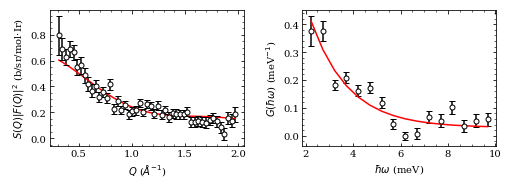

In [24]:
#Note that this method returns the value of S(Q), which is independent of the magnetic form factor.
from thpyutils.neutron.magAnalysis import getMagFF
from lmfit import Model, Parameters
from thpyutils.fitting import calcParamUncertainty
import numpy as np

FFsqr = getMagFF(factorresult[0],'Ir4')

##

def nnmodel(q,A):
    #Simple nearest neighbor correlation assuming a heisenberg-type interaction. Also works for Kitaev case.
    return A*(1.0+np.sin(q*3.54)/(q*3.54))

def pwrlaw(e,alpha,a,b):
    # Power law model for spectra.
    return a*np.exp(alpha*e)+b

sqmodel = Model(nnmodel, independent_vars=['q'])
sqparams = sqmodel.make_params()
sqparams.add('A',value=1.0,min=-10,max=10)

gemodel = Model(pwrlaw,independent_vars=['e'])
geparams = gemodel.make_params()
geparams.add('alpha',value=-0.5,min=-10,max=10)
geparams.add('a',value=1.0,min=0,max=100)
geparams.add('b',value=0,min=-100,max=100)

q,sq,sqerr = factorresult[0],factorresult[1],factorresult[2]
sqresult = sqmodel.fit(sq,q=q,weights=1.0/sqerr,params=sqparams,method='powell')
sqParamErrs = calcParamUncertainty(obs_vals=sq,obs_errs=sqerr,independent_vars={'q':q}, overwrite_prev=False,
                                   model=sqmodel,result=sqresult,show_plots=False,fname='sqfiterrs')
print('Error report for S(Q) fitting:')
for key in sqParamErrs.keys():
    print(f"Param {key}= {sqresult.params[key].value:.2e} ({sqParamErrs[key]:.2e})")

e,ge,geerr = factorresult[3],factorresult[4],factorresult[5]
geresult = gemodel.fit(ge,e=e,weights=1.0/geerr,params=geparams,method='powell')
# Get uncertainties for the parameters.
geParamErrs = calcParamUncertainty(obs_vals=ge,obs_errs=geerr,independent_vars={'e':e}, overwrite_prev=False,
                                   model=gemodel,result=geresult,show_plots=False,fname='gefiterrs')
print('\nError report for G(omega) fitting:')
for key in geParamErrs.keys():
    print(f"Param {key}= {geresult.params[key].value:.2e} ({geParamErrs[key]:.2e})")

fig,ax = plt.subplots(1,2,figsize=(8,2.5))
fig.subplots_adjust(wspace=0.3)
ax[0].plot(q,FFsqr*sqresult.best_fit,color='r',ls='-',marker=' ')
ax[0].errorbar(factorresult[0],FFsqr*factorresult[1],FFsqr*factorresult[2],color='k')
txt=ax[0].set_ylabel(r"$S(Q)|F(Q)|^2$ (b/sr/mol$\cdot$Ir)")
txt=ax[0].set_xlabel(r"$Q$ ($\AA^{-1}$)")

ax[1].errorbar(e,ge,geerr,color='k')
ax[1].plot(e,geresult.best_fit,color='r',marker=' ',ls='-')
txt=ax[1].set_xlabel(r"$\hbar\omega$ (meV)")
txt=ax[1].set_ylabel(r"$G(\hbar\omega$) (meV$^{-1}$)")

In [20]:
# Finally, a total moment sum rule can be used to evaluate the total observed moment.
from thpyutils.fitting.trapzErr import trapzErr

q_eval = np.linspace(0.02,3,1000)
sq_eval = sqmodel.eval(q=q_eval,params=sqresult.params)

frac_err = 0.3 # as a percent error from normalization
err_factor = sqParamErrs['A'] / sqresult.params['A'].value
tot_frac_err = np.sqrt(frac_err**2 + err_factor**2)
mu_eff = np.sqrt(3.0*(2.0**2)*np.trapz(sq_eval*(q_eval**2),x=q_eval)/np.trapz(q_eval**2,x=q_eval))
muerrsqr = 3.0*(2.0**2)*trapzErr(q_eval,sq_eval*(q_eval**2)/np.trapz(q_eval**2,x=q_eval), tot_frac_err*sq_eval*(q_eval**2)/np.trapz(q_eval**2,x=q_eval))
muerr = mu_eff*(muerrsqr/mu_eff**2 )
print(f"Effective moment extracted from factorization={mu_eff:.2f}({muerr:.3f}) muB")

Effective moment extracted from factorization=2.03(0.047) muB
